---
# Разведывательный анализ данных (EDA)
---

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их  
успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в  
группе риска.  
Нужно построить модель, которая предсказывала бы результаты госэкзамена по математике  
для каждого ученика школы.  
Наш датасет находится <a href="https://lms.skillfactory.ru/assets/courseware/v1/425d6864db937e4ebabc972e581769ab/asset-v1:Skillfactory+DST-10+22JAN2020+type@asset+block/stud_math.csv">здесь</a>.

In [6]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import random

from itertools import combinations

from scipy.stats import ttest_ind

# стили для темной темы
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', fscale=1.7, ticks=True,
             figsize=(8, 6.5))

pd.set_option('display.max_rows', 50) # больше строк

pd.set_option('display.max_columns', 50) # больше колонок

df = pd.read_csv('stud_math.csv')

Для начала посмотрим на данные.

In [7]:
print(f'В датасете {df.shape[0]} объектов и {df.shape[1]} признаков.')

В датасете 395 объектов и 30 признаков.


In [8]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [9]:
# Посмотрим на типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

---
# Первичная обработка данных.
---

In [10]:
# Приведем названия признаков к нижнему регистру
df.columns = list(map(lambda s: s.lower(), df.columns))

In [11]:
# Удалим возможные дубликаты если они есть.
df.drop_duplicates(inplace=True)
df.shape

(395, 30)

После попытки удаления дубликатов, размерность выборки не изменилась. Данные уникальны.

При первичном осмотре данных заметил явную обратную корреляцию между признаками studytime и  
studytime, granular.  
Проверим это с помощью матрицы парных коэффициентов корреляции для положительной и  
отрецательной корреляции.

In [12]:
cor_df = df.corr()
cor_df[(cor_df > 0.95) | (cor_df < -0.95)]

,age,medu,fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medu,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fedu,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traveltime,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studytime,NaN,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
failures,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"studytime, granular",NaN,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
famrel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
freetime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
goout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


Предпоположение подтвердилось.  
Удалим признак **studytime, granular** из набора данных.  

In [13]:
df.drop(columns=['studytime, granular'], inplace=True)

---
### Разделение признаков на типы ( непрерывные, номинативные)

In [14]:
# напишем функцию, определяющую тип признака (категориальный или непрерывный)
def categorize_features(data, n=3):
    """
    Класифицирует признаки на непрерывные и категориальные.
    Признает признак категориальным если количество уникальных
    значений меньше или равно n.
    
    Возвращает список из двух элементов, являющихся списков с
    названиями признаков, относящихся либо одной из двух категорий.
    """
    categoricals = [c for c in df.columns if df[c].dtype.name == 'object' \
                    or df[c].nunique() <= n]
    numericals = list(set(df.columns).difference(set(categoricals)))
    
    return [categoricals, numericals]

In [15]:
categorical_columns, numerical_columns = categorize_features(df, 6)

--- 
#### Непрерывные признаки

In [16]:
# Получим некоторую общую информацию по непрерывным признакам
descriptive_continuous_stats = df[numerical_columns].describe()
descriptive_continuous_stats

,age,score,absences
count,395.000000,389.000000,383.000000
mean,16.696203,52.262211,7.279373
std,1.276043,22.919022,23.465197
min,15.000000,0.000000,0.000000
25%,16.000000,40.000000,0.000000
50%,17.000000,55.000000,4.000000
75%,18.000000,70.000000,8.000000
max,22.000000,100.000000,385.000000


По непрерывным признакам видно:  
- **score** - имеет пропуски. Объкты, содержащие пропуски, стоит удалить, т.к. это целевой признак.  
- **absences** - имеет пропуски и явные выбросы. Выбросы следует удалить.
- **age** - явно имеет выбросы, которые стоит удалить.

--- 
#### Номинативные признаки
Ввиду того, что к категориальным признакам функция categorize_features отнесла не только данные с  
типом  object,  
но так же с типом float и int, то посмотрим на них отдельно.

In [17]:
# Категориальные числовые признаки
df[categorical_columns].describe()

,medu,fedu,traveltime,studytime,failures,famrel,freetime,goout,health
count,392.000000,371.000000,367.000000,388.000000,373.000000,368.000000,384.000000,387.000000,380.000000
mean,2.750000,2.614555,1.438692,2.038660,0.337802,3.937500,3.231771,3.105943,3.531579
std,1.098127,2.228732,0.694181,0.842078,0.743135,0.927277,0.993940,1.115896,1.396019
min,0.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000
50%,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000
75%,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000
max,4.000000,40.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000


In [18]:
display(df.fedu.value_counts())
display(df.famrel.value_counts())

2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: fedu, dtype: int64

 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

В описательных статистиках категориальных признаков (числовых), наблюдаем следующее:  
- **fedu** - ошибка в данных (40)
- **famrel** - ошибка в данных (-1)  

Стоит устранить ошибки.

In [19]:
# Удалим ошибочные данные в fedu и в famrel
df = df.query("fedu != 40.0")
df = df.query("famrel != -1.0")

In [20]:
# Категориальные признаки
df[categorical_columns].describe(include=['object'])

,school,sex,address,famsize,pstatus,mjob,fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,393,393,376,366,350,374,357,376,362,384,354,353,379,377,373,359,362
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,347,206,293,259,314,133,196,137,249,333,217,199,194,299,354,303,238


In [21]:
# Обновим список типов признаков
categorical_columns, numerical_columns = categorize_features(df, 6)

Для удобства дальнейшей работы со всеми категориальными признаками, изменим тип данных  
на dtype='object'

In [22]:
df[categorical_columns] = df[categorical_columns].astype('object')

In [23]:
# Оценим описательные данные признаков нового типа
data_describe = df.describe(include=['object'])
data_describe

,school,sex,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health
count,393,393,376,366,350,390.0,369.0,374,357,376,362,365.0,386.0,371.0,384,354,353,379,377,373,359,362,366.0,382.0,385.0,378.0
unique,2,2,2,2,2,5.0,5.0,5,5,4,3,4.0,4.0,4.0,2,2,2,2,2,2,2,2,5.0,5.0,5.0,5.0
top,GP,F,U,GT3,T,4.0,2.0,other,other,course,mother,1.0,2.0,0.0,no,yes,no,yes,yes,yes,yes,no,4.0,3.0,3.0,5.0
freq,347,206,293,259,314,131.0,105.0,133,196,137,249,241.0,194.0,292.0,333,217,199,194,299,354,303,238,182.0,153.0,127.0,137.0


Почти все категориальные признаки, за исключением school и sex имеют пропуски данных.  
Посмотрим на уникальные значения каждого категориального признака, чтобы убедиться в отсутствии  
не корректных данных, за исключением пропусков.

In [24]:
for c in categorical_columns:
    print(f"{c}:\n{df[c].unique()}\n")

school:
['GP' 'MS']

sex:
['F' 'M']

address:
['U' nan 'R']

famsize:
[nan 'GT3' 'LE3']

pstatus:
['A' nan 'T']

medu:
[4.0 1.0 3.0 2.0 nan 0.0]

fedu:
[4.0 1.0 2.0 3.0 nan 0.0]

mjob:
['at_home' 'health' 'other' 'services' 'teacher' nan]

fjob:
['teacher' 'other' nan 'health' 'services' 'at_home']

reason:
['course' 'other' 'home' 'reputation' nan]

guardian:
['mother' 'father' 'other' nan]

traveltime:
[2.0 1.0 3.0 nan 4.0]

studytime:
[2.0 3.0 1.0 nan 4.0]

failures:
[0.0 3.0 nan 1.0 2.0]

schoolsup:
['yes' 'no' nan]

famsup:
['no' 'yes' nan]

paid:
['no' nan 'yes']

activities:
['no' 'yes' nan]

nursery:
['yes' 'no' nan]

higher:
['yes' nan 'no']

internet:
[nan 'yes' 'no']

romantic:
['no' nan 'yes']

famrel:
[4.0 5.0 3.0 nan 2.0 1.0]

freetime:
[3.0 2.0 4.0 1.0 5.0 nan]

goout:
[4.0 3.0 2.0 1.0 5.0 nan]

health:
[3.0 5.0 1.0 2.0 4.0 nan]



---
## Пропуски данных 

In [25]:
# Оценим количество пропущенных данных
df.isnull().sum()

school         0
sex            0
age            0
address       17
famsize       27
pstatus       43
medu           3
fedu          24
mjob          19
fjob          36
reason        17
guardian      31
traveltime    28
studytime      7
failures      22
schoolsup      9
famsup        39
paid          40
activities    14
nursery       16
higher        20
internet      34
romantic      31
famrel        27
freetime      11
goout          8
health        15
absences      12
score          6
dtype: int64

Перед заполнением пропусков создадим дополнительные бинарные признаки, имеющие название  
**"признак + _ex"**.  
Так мы будем в дальнейшем понимать является ли значение исходного признака настоящим или  
синтетическим, созданным нами при обработке пропусков. 

In [26]:
# Создадим новые признаки 
for name in df.columns[:-1]:
    df[f"{name}_ex"] = df[name].apply(lambda x: int(pd.notnull(x)))\
    .astype('object')

---
### Непрерывные признаки

In [27]:
# Удалим из датасета строки с пропусками значений целевого признака score
df.dropna(subset=['score'], inplace=True)

In [28]:
# Заменим пропуски в признаке absences медианным значением
df.absences.fillna(df.absences.median(), inplace=True)

### Категориальные признаки 

In [29]:
# Выберем категориальные признакм, нуждающиеся в заполнении
cat_col_to_fill = categorical_columns[2:]

In [30]:
# Заполним пропуски частотными значениями
data_describe = df[cat_col_to_fill].describe()
for c in cat_col_to_fill:
    df[c] = df[c].fillna(data_describe[c]['top'])

In [31]:
# Убедимся, что пропусков нет.
df[cat_col_to_fill].isnull().sum()

address       0
famsize       0
pstatus       0
medu          0
fedu          0
mjob          0
fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
health        0
dtype: int64

## Удаление выбросов (Outliers)
Напишем несколько функций для получения данных о выбросах, визуализации и их удаления.

In [32]:
def get_stat_metrics(s):
    """
    Функция получает объект типа pandas.Series
    Расчитывает основные статистики:
    median - медиана
    perc25, perc75 - нижний и верхний квартили
    IQR - межквартильный размах
    bottom_border - нижняя граница
    upper_border - верхняя граница
    Возвращает словарь статистических значений.
    """
    q1 = s.quantile(0.25)
    q2 = s.median()
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    minimum = s.min()
    maximum = s.max()
    
    names = 'q1 q2 q3 iqr fence_low fence_high minimum maximum'.split(' ')
    
    stats = dict(zip(names,
                     [q1, q2, q3, iqr, fence_low, \
                      fence_high, minimum, maximum]))
    
    return stats

In [33]:
def histogram(data, title=""):
    """
    data - объект типа pandas.Series
    Выводит гистрограмму признака data
    на экран.
    """
    n_bins = round(len(data)/10)
    _, ax = plt.subplots(figsize=(7,6))
    ax.hist(data, bins=n_bins, color='#539caf')
    ax.set_title(title)

In [34]:
def two_histogram(data_1, data_2, title_1='', title_2=''):
    """
    data_1, data_2 - объекты типа pandas.Series
    Выводит в ряд 2 гистрограммы для визуального сравнения.
    """
    data_range = [min(min(data_1), min(data_2)), max(max(data_1), \
                                                     max(data_2))]
    
    fig, axs = plt.subplots(1, 2, figsize=(14,6))
    n_bins = round(max(len(data_1)/10, len(data_2)/10))

    axs[0].hist(data_1, bins=n_bins, range=data_range, color='#539caf')
    axs[0].set_title(title_1)
    
    axs[1].hist(data_2, bins=n_bins, range=data_range, color='#539caf')
    axs[1].set_title(title_2)


In [35]:
# Зададим функцию для вывода на экран стат метрик по признаку
def show_stat_data(s):
    """
    Выводит на экран в удобочитаемом виде
    статистические данные.
    Уведомляет о наличии выбросов.
    Рисует гистрограмму распределения признака.
    В случае наличия выбросов, рисует дополнительную
    гистрамму без выбросов.
    """
    
    sd = get_stat_metrics(s) # sd - statistics data
    print(f'Признак {s.name}:')
    print(f"25-й перцентиль: {sd['q1']}, медиана: {sd['q2']},", \
          f"75-й перцентиль: {sd['q3']},", f"IQR: {sd['iqr']}.")
    print(f"Границы выбросов: [{sd['fence_low']}, {sd['fence_high']}]")
    print(f"Диапазон значений: [{sd['minimum']}, {sd['maximum']}]")
    
    if (sd['minimum']<sd['fence_low']) or (sd['maximum']>sd['fence_high']):
        print(f"В данных имеются выбросы!\n")
        # s_w_o - s without outliers
        s_w_o = s.loc[s.between(sd['fence_low'], sd['fence_high'])]
        two_histogram(s, s_w_o, title_1=f"fact {s.name}", \
                      title_2=f"{s.name} without outliers")
    else:
        print(f"Выбросов нет\n")
        histogram(s, title=f"{s.name}")

Признак age:
25-й перцентиль: 16.0, медиана: 17.0, 75-й перцентиль: 18.0, IQR: 2.0.
Границы выбросов: [13.0, 21.0]
Диапазон значений: [15, 22]
В данных имеются выбросы!

Признак score:
25-й перцентиль: 40.0, медиана: 55.0, 75-й перцентиль: 70.0, IQR: 30.0.
Границы выбросов: [-5.0, 115.0]
Диапазон значений: [0.0, 100.0]
Выбросов нет

Признак absences:
25-й перцентиль: 0.0, медиана: 4.0, 75-й перцентиль: 8.0, IQR: 8.0.
Границы выбросов: [-12.0, 20.0]
Диапазон значений: [0.0, 385.0]
В данных имеются выбросы!



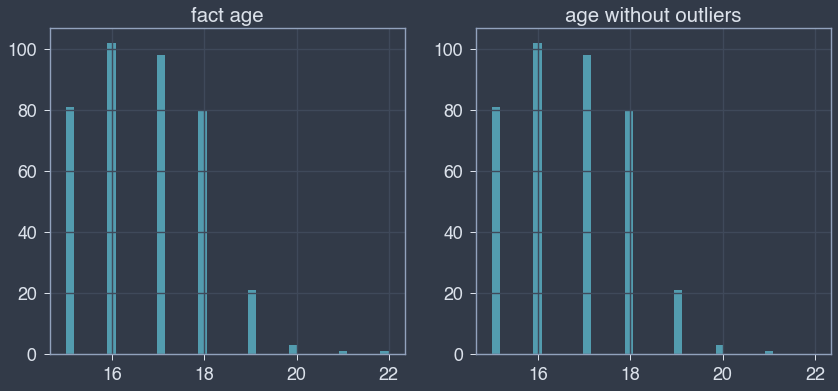

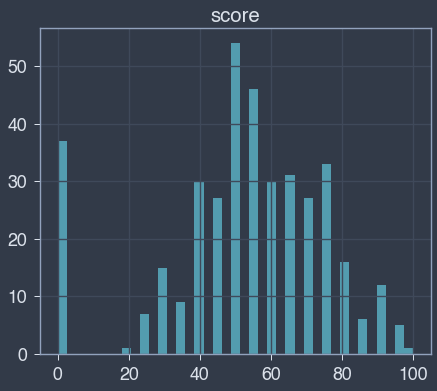

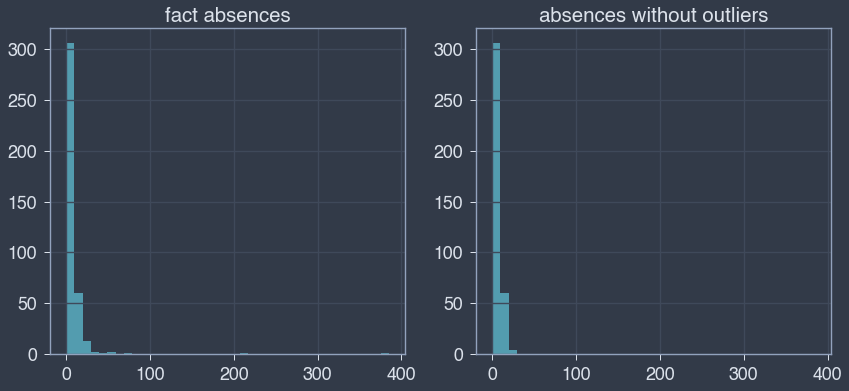

In [36]:
for col in numerical_columns:
    show_stat_data(df[col])

In [145]:
df[numerical_columns].describe()

,age,absences,score
count,387.000000,387.000000,387.000000
mean,16.679587,7.217054,52.273902
std,1.265596,23.342004,22.966464
min,15.000000,0.000000,0.000000
25%,16.000000,0.000000,40.000000
50%,17.000000,4.000000,55.000000
75%,18.000000,8.000000,70.000000
max,22.000000,385.000000,100.000000


In [146]:
def remove_outlier(df_in, col_name):
    """
    df_in - объект типа pandas.DataFrame
    col_name - тип string
    Возвращает объект pandas.DataFrame без выбросов.
    """
    stats = get_stat_metrics(df_in[col_name])
    
    df_out = df_in.loc[df_in[col_name].between(stats['fence_low'], \
                                               stats['fence_high'])]
    
    return df_out

In [147]:
# Удалим выбросы из непрерывных данных
for col in numerical_columns[:-1]:
    df = remove_outlier(df, col)

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 394
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   school         369 non-null    object 
 1   sex            369 non-null    object 
 2   age            369 non-null    int64  
 3   address        369 non-null    object 
 4   famsize        369 non-null    object 
 5   pstatus        369 non-null    object 
 6   medu           369 non-null    float64
 7   fedu           369 non-null    float64
 8   mjob           369 non-null    object 
 9   fjob           369 non-null    object 
 10  reason         369 non-null    object 
 11  guardian       369 non-null    object 
 12  traveltime     369 non-null    float64
 13  studytime      369 non-null    float64
 14  failures       369 non-null    float64
 15  schoolsup      369 non-null    object 
 16  famsup         369 non-null    object 
 17  paid           369 non-null    object 
 18  activities

---
## Корреляционный анализ 

Построим графики зависимостей переменных с помощью модуля seaborn

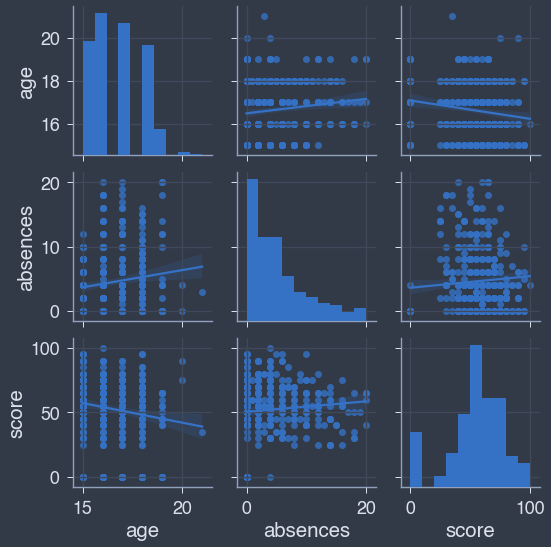

In [149]:
sns.pairplot(df[numerical_columns], kind = 'reg')

In [150]:
# Используем для наглядности матрицу корреляций
df[numerical_columns].corr()

,age,absences,score
age,1.000000,0.134266,-0.161105
absences,0.134266,1.000000,0.085719
score,-0.161105,0.085719,1.000000


### Выводы
Мы имеем 2 слабоскоррелированные с целевым признаком переменные: **age** и **absences**  
При этом наблюдаются странные тенденции:
- **age** - отрицательная корреляция, чем выше возраст, тем значения score ниже. Возможно на  
это влияют значения номинативных признаков, например признака **romantic**
- **absences** - положительная корреляция, чем больше пропусков, тем выше значения score.

Оставляем оба этих признака для дальнейшей работы с моделью.

---
## Анализ номинативных переменных

Посмотрим, различаются ли распределения целевой переменной score от значения номинативных  
переменных. Используем для этого boxplot

In [151]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column]
                                                   .value_counts()
                                                   .index[:10])],ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

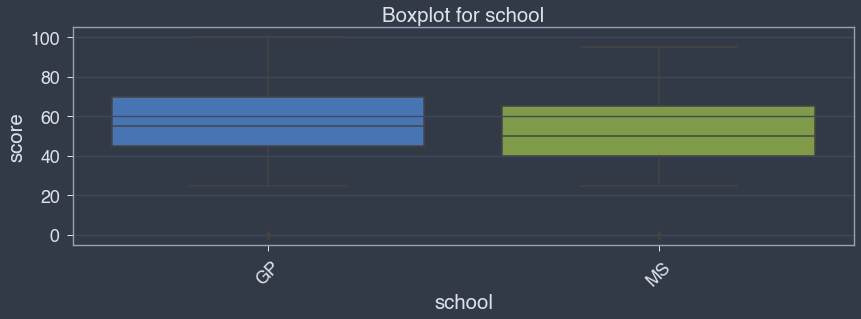

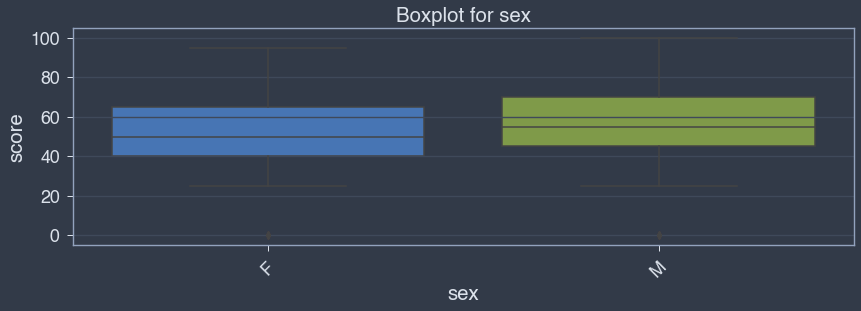

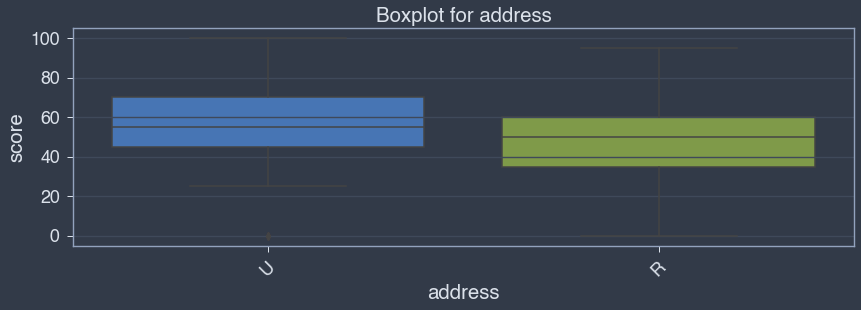

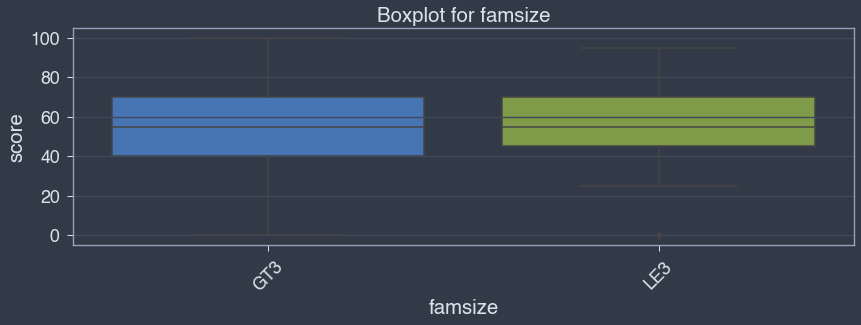

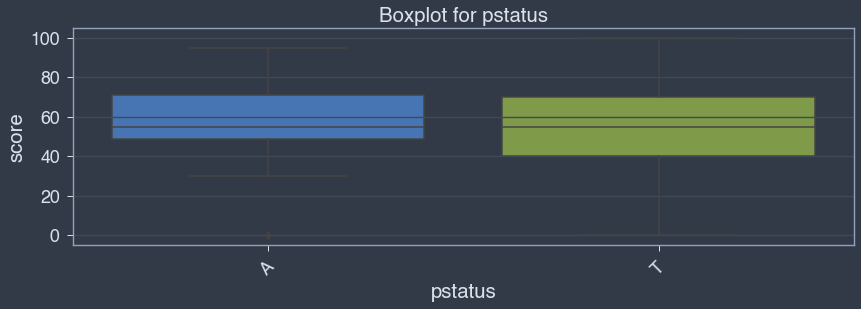

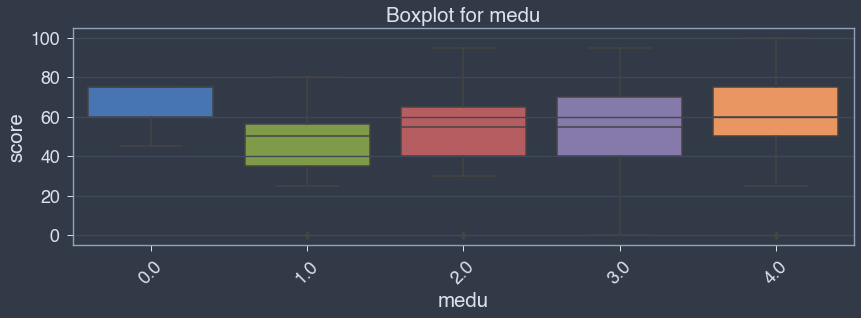

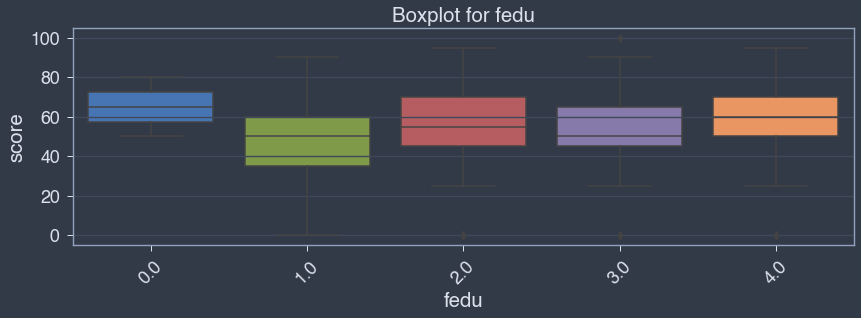

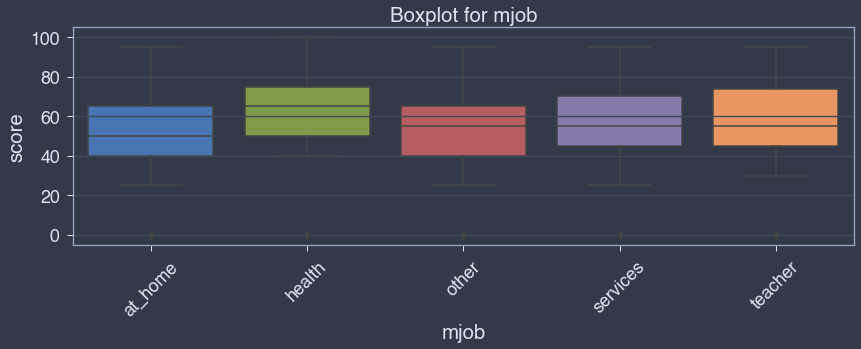

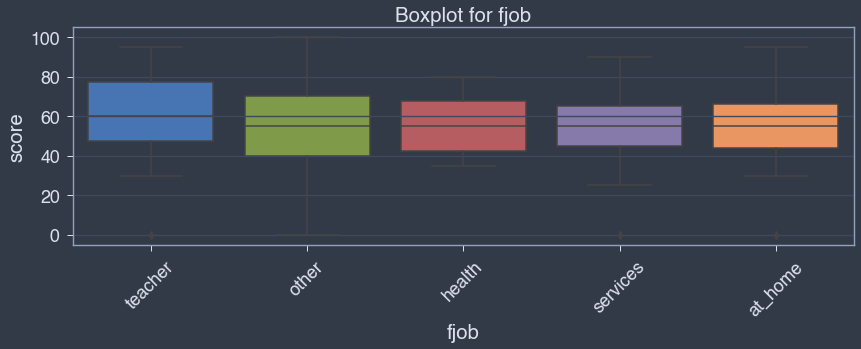

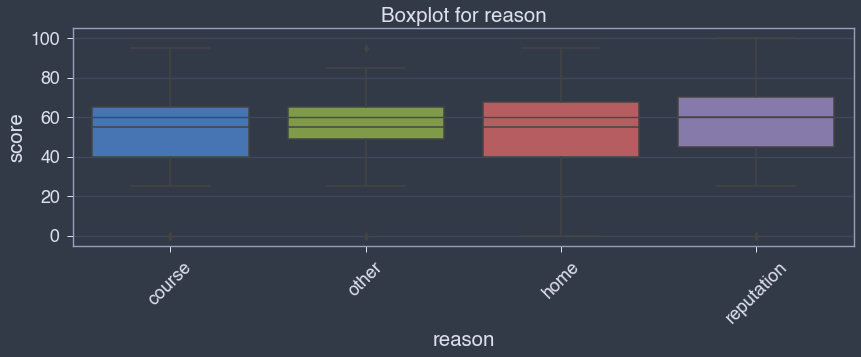

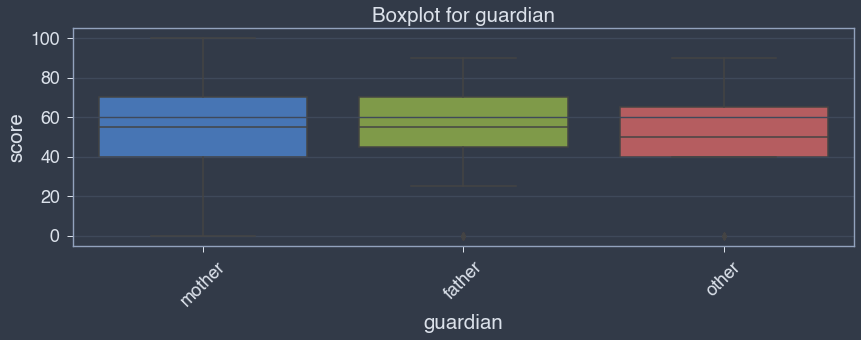

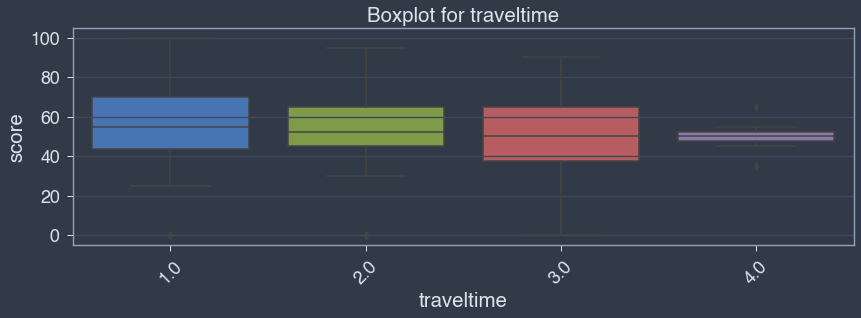

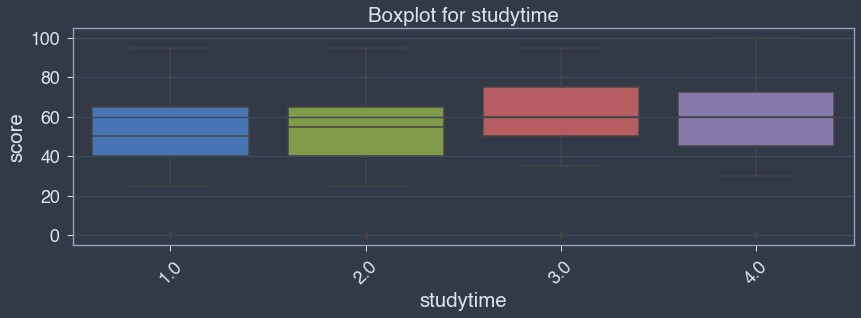

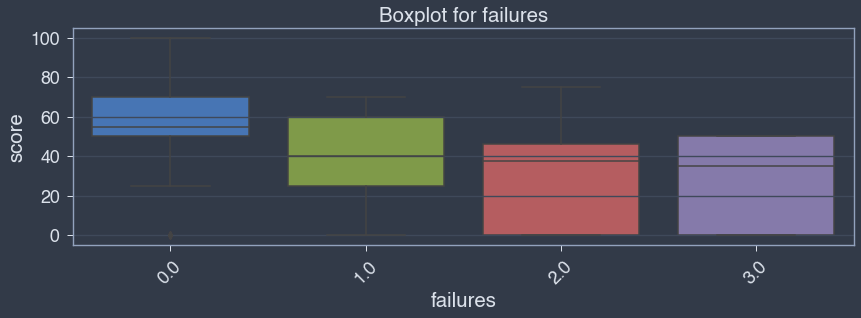

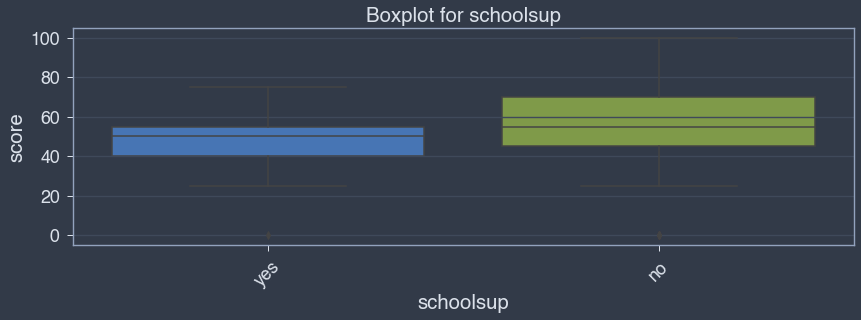

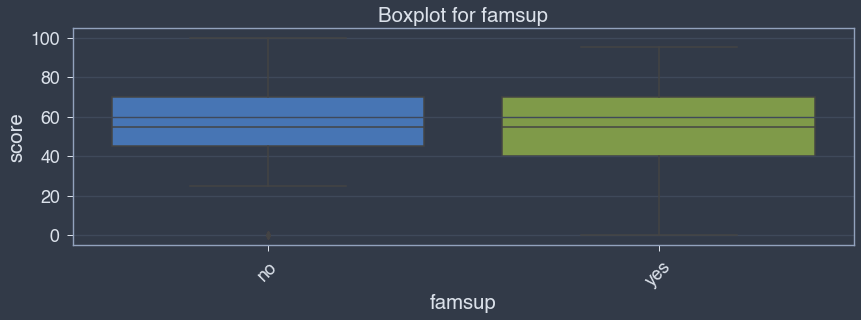

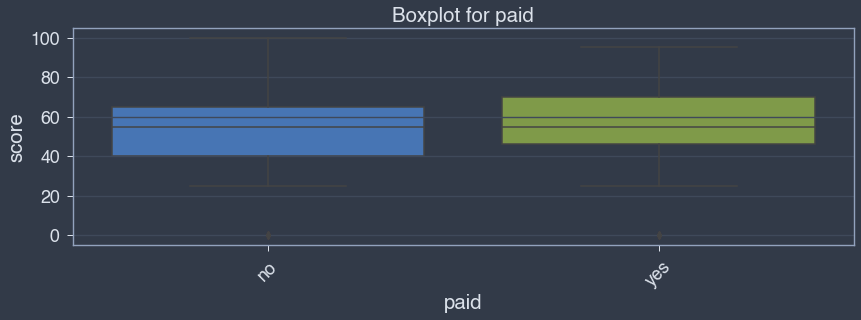

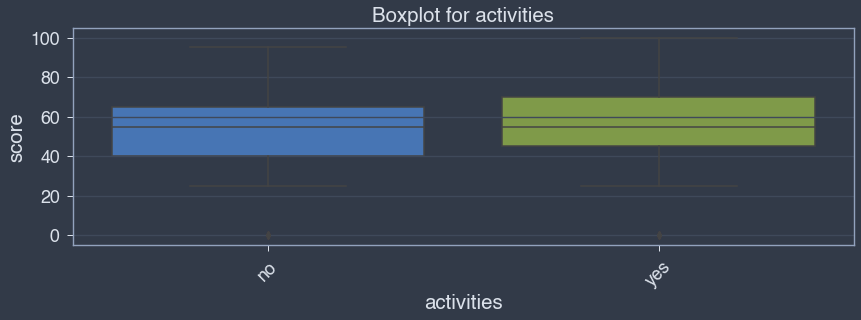

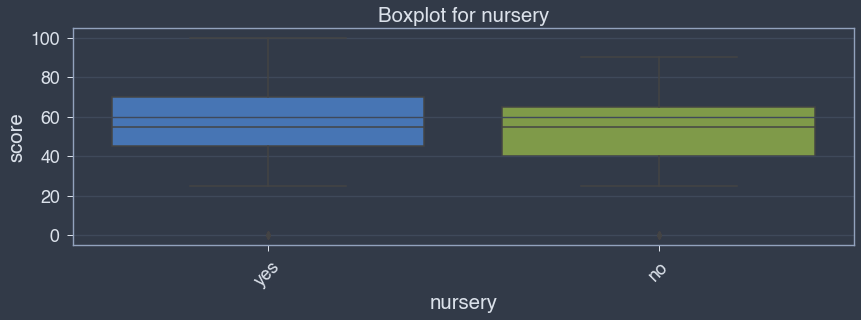

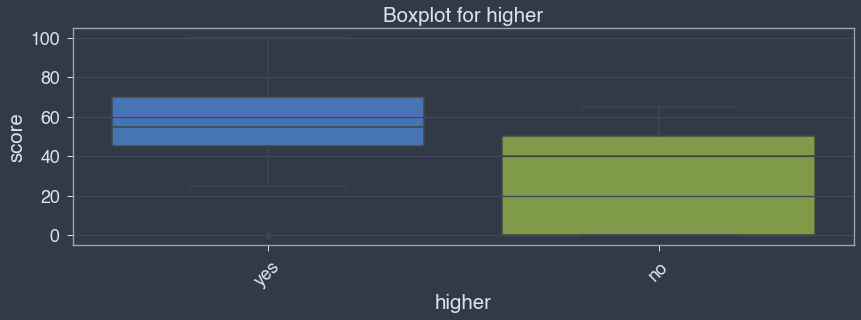

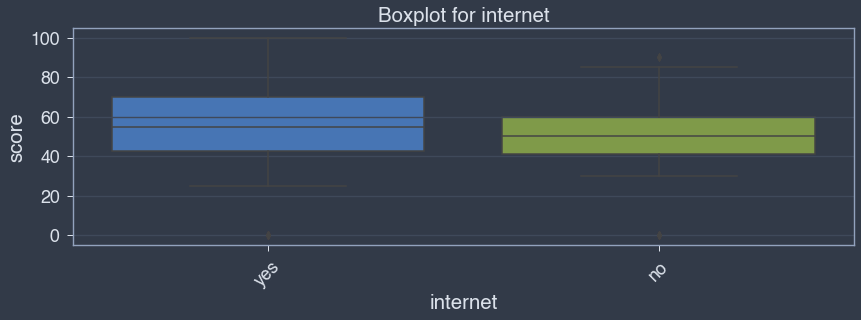

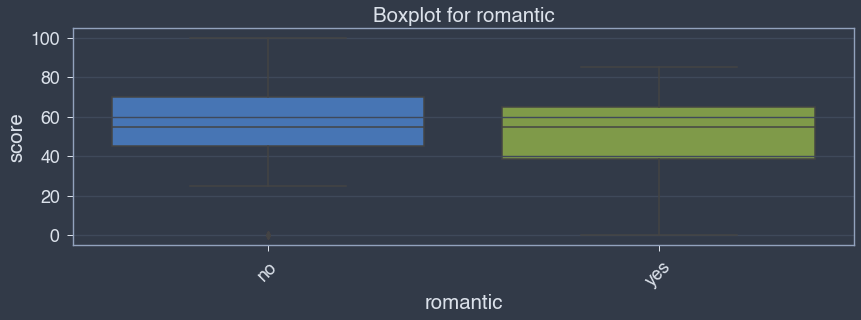

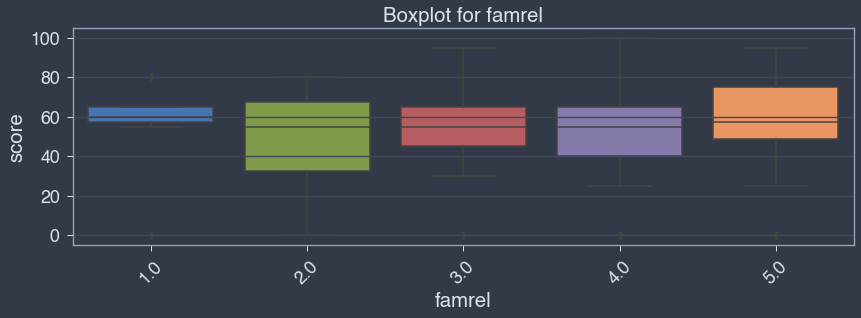

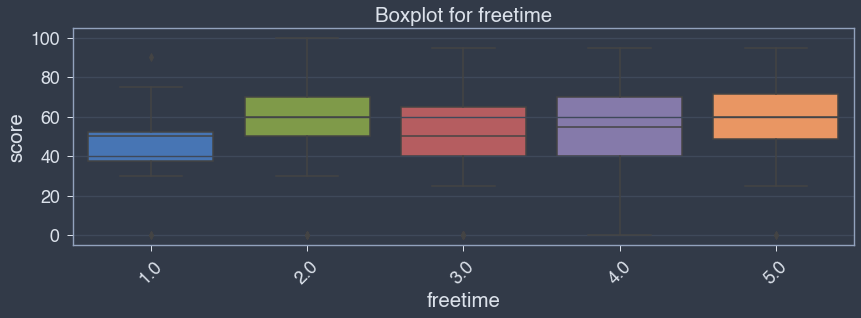

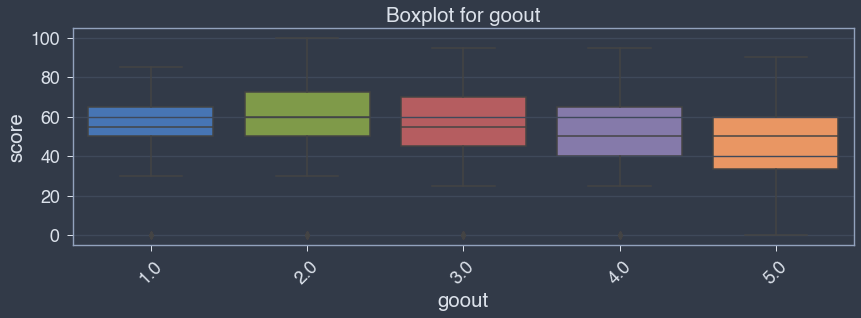

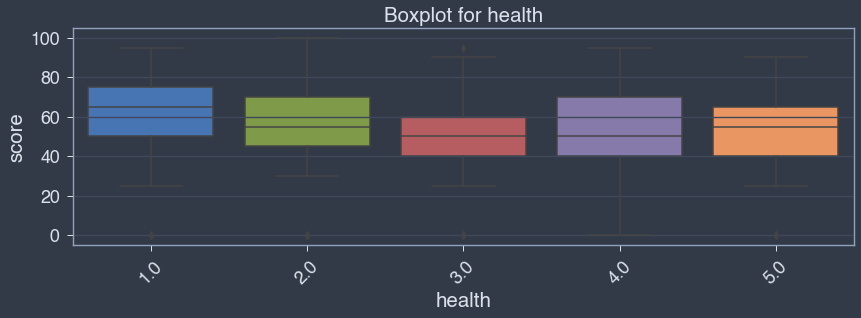

In [152]:
for col in categorical_columns:
    get_boxplot(col)

Проверим так же есть ли статистическая значимость в распределении оценок по номинативным  
признакам, с помощью **теста Стюдента**.  
Проверим **нулевую гипотезу** о том, что распределения оценок батончиков по различным  
параметрам **не различимы**.  

In [153]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                    df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print(f"Найдены стат. значимые различия для признака: {column}")
            break

In [154]:
for col in categorical_columns:
    get_stat_dif(col)

Найдены стат. значимые различия для признака: sex
Найдены стат. значимые различия для признака: address
Найдены стат. значимые различия для признака: medu
Найдены стат. значимые различия для признака: mjob
Найдены стат. значимые различия для признака: failures
Найдены стат. значимые различия для признака: paid
Найдены стат. значимые различия для признака: higher
Найдены стат. значимые различия для признака: romantic


Как мы видим, статистические значимые результаты, что параметр влияет на целевой признак, имеются у следующих признаков:
- **sex** - лица мужского пола имеют более высокий балл,
- **address** - проживающие в городе имеют более высокий бал. Видимо они более мотивированы построить карьеру с обязательным требованием точных наук,
- **medu** - достаточно странное наблюдение, так как при отсутсвии образования у матери и при наличии высшего образования, значения целевого признака практичесчки одинаковы,
- **mjob** - при значении признака health и teacher наблюдаем самые высокие значения целевого признака,
- **failures** - явно заметна тенденция, чем больше у учащегося было неудач, тем ниже значения целевого признака.
- **paid** - платные занятия по математике способствуют более высоким значениям score.
- **higher** - намерение получить высшее образование, определенно, способствуют более высоким значениям score
- **romantic** - ученики, не имеющие отношений с противополжным полом, имеют более высокие значения score

Получается, что из 26 номинативных переменных, оставим только вышеперечисленные для дальнейшего построения модели.  

Таким образом, считаю важными переменными, которые **оказывают влияние на предсказываемую величину score**, это:
- **age**,
- **absebces**,
- **sex**,
- **address**,
- **medu**,
- **mjob**,
- **failures**,
- **paid**,
- **higher**,
- **romantic**

Подготовим датасет для дальнего построения модели, а именно:  
- удалим переменные, не вошедшие в перечень, описанный выше,
- преобразуем не бинарные номинативные признаки, имеющие более 2 уникальных значений по принципу one-hot-кодирования.

In [155]:
# отобранные признаки для построения модели

selected_columns = numerical_columns[:2] + \
    'sex address medu mjob failures paid higher romantic'.split(' ') + \
    numerical_columns[-1:]

# Добавим еще бинарные признаки созданные нами на этапе обработки пропусков
# данных, которые тоже стоит удалить.
selected_columns += [f"{col}_ex" for col in selected_columns[:-1]]

In [156]:
# Удалим лишние столбцы из датафрейма
df_model = df.loc[:, selected_columns]

In [157]:
# Приведем признаки paid, higher, romantic к бинарному типу ( 0 или 1) без
# генерации доп. признаков.
df_model[['paid', 'higher', 'romantic']] = \
    df_model[['paid', 'higher', 'romantic']].replace({'no': 0, 'yes': 1})

In [158]:
# Перед применением ohe изменим тип признаков medu и failures на тип  int64
df_model.medu = df_model.medu.astype(int)
df_model.failures = df_model.failures.astype(int)

In [159]:
# Выберем параметры для последующего ohe-кодирования :
indicator_cols = 'sex address medu mjob failures'.split(' ')

In [160]:
# Напишем свою реализацию one-hot-кодировщика
def make_ohe(data, col_name):
    """
    data - объект типа pandas.DataFrame
    col_name - тип string - название признака
    Функция создает в data новые разряженные
    бинарные признаки по принципу
    one-hot-кодирования, удаляет прежний
    признак.
    """
    for i in data[col_name].unique():
        data[f"{col_name}_{i}"] = (data[col_name] == i).astype(float)
    data.drop([col_name], inplace=True, axis=1)


In [161]:
# Выполним ohe-кодирование для выбранных признаков.
for name in indicator_cols:
    make_ohe(df_model, name)

---
# Выводы

В результате проведенного разведывательного анализа влияния различных параметров учащегося на итоговый бал на экзамене по математике получены следующие выводы:
- В данных достаточно мало пустых значений. Кол-во пропусков было, по некоторым признакам, чуть больше 10%
- Данные не содержали дубликатов, что говорит об уникальности данных
- Выбросы найдены в признаках age, absences.
- Всего по 1 ошибке было выявлено в признаках fedu и в famrel
- Отрицательная корреляция параметра **age** может говорить о том, что с возрастом ученики начинают романтические отношения и успеваемость отходит на второй план. Выявленные статистически значимые различия параметра **romantic** так же дают основания не отвергать эту гипотезу.
- Самыми выжными параметрами, которые предлагается использовать в дальнейшем для построения модель, это:
 - **age**,
 - **absebces**,
 - **sex**,
 - **address**,
 - **medu**,
 - **mjob**,
 - **failures**,
 - **paid**,
 - **higher**,
 - **romantic**